In [1]:
# Imports
import os
from datasets import Audio, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback, set_seed
import torch
from torchvision import transforms
import torchaudio 
import torchaudio.transforms as T
import numpy as np
from datasets import Dataset
import random
from PIL import Image, ImageOps
from evaluate import load
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import shutil, os
import librosa

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Parameters
model_name = "google/vit-base-patch16-224-in21k" 
processor = ViTImageProcessor.from_pretrained(model_name)
sample_rate = 22050
epochs = 30
training_args = {
    "output_dir": "./vit-base-manuai-peft",  # save PEFT checkpoints here (separate from merged model)
    "remove_unused_columns": False,
    "learning_rate": 5e-4,  # Learning rate for fine-tuning
    "lr_scheduler_type": "cosine",  # Learning rate scheduler type
    "warmup_ratio": 0.1,  # Warmup ratio for learning rate scheduler
    "per_device_train_batch_size": 8,  # Batch size per device during training 
    "fp16": False,  # Disable mixed precision training
    "bf16": False,  # Disable bfloat16 training
    #"no_cuda": True,  # Disable CUDA to avoid GPU memory issues
    "logging_steps": 100, # Log every 100 steps
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "eval_strategy": "epoch",  # Evaluate at the end of each epoch
    "save_strategy": "epoch",  # Save model at the end of each epoch
    "save_total_limit": 1,  # Limit the number of saved checkpoints
    "label_names": ["labels"],
    "weight_decay": 0.001,  # Weight decay for regularization
    "report_to": "tensorboard",
    "load_best_model_at_end": True,
}
n_proc = 1  # Number of processes for parallel processing
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)
metric = load("accuracy")
training_size = int(input("Enter the amount of spectrograms per class to train on (0 for all, default 100): ") or 100)

In [3]:
"""
Load the dataset from the specified path and convert audio data into Mel Spectrograms.
Directory structure:
segments/
├── {english_name}
│   ├── {scientific_name}_{scientific_subspecie}
│   │   ├── {english_name}_{scientific_name}_{scientific_subspecie}_{song}_segment_{num}.wav
"""

def augment_audio(sample, force_augment=False):
    waveform, sample_rate = torchaudio.load(sample["audio"]["path"])

    if force_augment or random.random() < 0.7:
        # Apply pitch shifting                      ````````````````````````
        if random.random() < 0.8:
            n_steps = random.uniform(-3, 3)
            waveform = T.PitchShift(sample_rate, n_steps=n_steps)(waveform)

        # Apply time stretching (correctly)
        if random.random() < 0.8:
            stretch_factor = random.uniform(0.8, 1.2)
            # Convert to spectrogram
            n_fft = 2048
            window = torch.hann_window(n_fft)
            hop_length = 512
            spec = torch.stft(
                waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True
            )
            # Apply TimeStretch
            time_stretch = T.TimeStretch(hop_length=hop_length, n_freq=spec.size(1))
            spec_stretched = time_stretch(spec, stretch_factor)
            # Convert back to waveform
            waveform = torch.istft(spec_stretched, n_fft=n_fft, hop_length=hop_length)

        # Add noise
        if random.random() < 0.5:
            noise = torch.randn_like(waveform) * 0.01
            waveform = waveform + noise

        # Apply frequency masking
        if random.random() < 0.5:
            waveform = T.FrequencyMasking(freq_mask_param=20)(waveform)

    sample["audio"] = {
        "array": waveform.detach().numpy(),
        "sampling_rate": sample_rate,
        "path": sample["audio"]["path"]
    }
    return sample

segments_path = "./segments"
merged_output_dir = "./vit-base-manuai"

labels = set()

# Collect file paths by class
label_to_files = {}
for root, dirs, files in os.walk(segments_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            parts = os.path.splitext(file)[0].split('_')
            if len(parts) >= 2:
                english_name = parts[1]  # Extract label from filename
                labels.add(english_name)
                if english_name not in label_to_files:
                    label_to_files[english_name] = []
                label_to_files[english_name].append(path)

labels = sorted(list(labels))  # deterministic ordering
print("Final label order:", labels)

# Create dataset with up to training_size files per class
data = []
for label, files in label_to_files.items():
    random.shuffle(files)  # Randomize file order
    selected_files = files[:training_size]  # Select up to training_size
    # If not enough files, augment audio
    if len(selected_files) < training_size:
        augmented_samples = []
        while len(selected_files) + len(augmented_samples) < training_size and len(selected_files) > 0:
            file = random.choice(selected_files)
            sample = {"audio": {"path": file}, "label": label}
            augmented_samples.append(augment_audio(sample, force_augment=True))
        selected_files.extend([s["audio"]["path"] for s in augmented_samples])
    # Add samples to data
    for file in selected_files[:training_size]:  # Ensure exactly training_size
        data.append({"audio": {"path": file}, "label": label})

# Create dataset
dataset = Dataset.from_list(data)

dataset = dataset.shuffle(seed=42)

# Cast audio column to use soundfile backend
dataset = dataset.cast_column("audio", Audio(decode=False))

if not dataset:
    print("🚨 Dataset could not be loaded. Check the dataset path and structure.")
if "audio" not in dataset.column_names:
    print("🚨 Dataset does not contain 'audio' column. Check the dataset structure.")

print(f"✅ Dataset loaded with {len(dataset)} samples.")
dataset['audio']

Final label order: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/functional.py:730: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggere

✅ Dataset loaded with 12000 samples.


Column([{'bytes': None, 'path': './segments/silvereye/zosterops_lateralis/962315_silvereye_zosterops_lateralis_song_segment_60.wav'}, {'bytes': None, 'path': './segments/saddleback/philesturnus_rufusater/925455_saddleback_philesturnus_rufusater_call_song_segment_13.wav'}, {'bytes': None, 'path': './segments/whitehead/mohoua_albicilla/293308_whitehead_mohoua_albicilla_call_song_segment_55.wav'}, {'bytes': None, 'path': './segments/tui/prosthemadera_novaeseelandiae/500854_tui_prosthemadera_novaeseelandiae_song_segment_24.wav'}, {'bytes': None, 'path': './segments/fantail/rhipidura_fuliginosa/926858_fantail_rhipidura_fuliginosa_song_segment_232.wav'}])

✅ Unique labels found: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
Sample dataset entry: {'audio': {'bytes': None, 'path': './segments/silvereye/zosterops_lateralis/962315_silvereye_zosterops_lateralis_song_segment_60.wav'}, 'label': 'silvereye'}


Converting audio to Mel Spectrograms: 100%|██████████| 12000/12000 [04:08<00:00, 48.37 examples/s] 


✅ Converted Mel Spectrograms for 12000 samples.


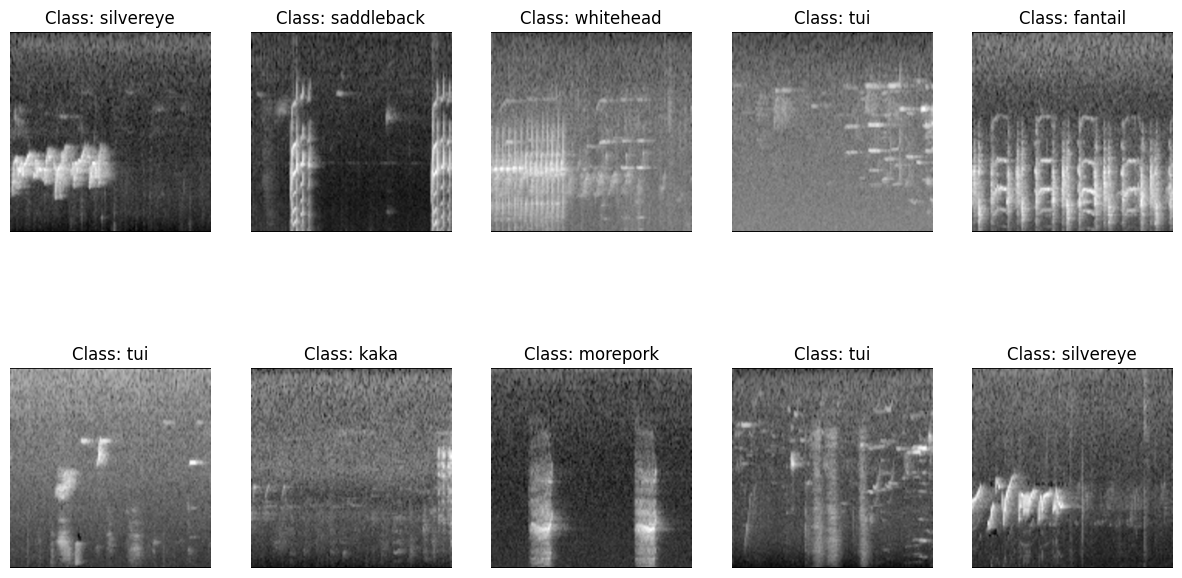

✅ Dataset transformed for model input.


In [4]:
def convert_to_mel_spectrogram(sample):
    """
    Convert audio waveform to Mel Spectrogram.
    """
    audio_path = sample["audio"]["path"]
    y, sr = librosa.load(audio_path, sr=sample_rate, mono=True)  # resample + mono here
    waveform = torch.from_numpy(y).unsqueeze(0)            # [1, T]
    mode = "basic_rgb"
    target_size = (224, 224)

    # Mel
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        win_length=768,
        n_mels=128,
        f_min=200,
        f_max=10000,
    )
    mel_spec = mel_spectrogram_transform(waveform)  # [1, n_mels, time]

    if mode == "3channel":
        # Channel 1: log-mel dB
        mel_spec_db = T.AmplitudeToDB()(mel_spec).squeeze(0).numpy()  # [n_mels, time]

        # Channel 2: PCEN
        mel_np = mel_spec.squeeze(0).numpy()  # [n_mels, time]
        mel_spec_pcen = librosa.pcen(mel_np * (2**31), sr=sample_rate)  # scale to avoid tiny values

        # Channel 3: delta
        delta_spec = librosa.feature.delta(mel_spec_db)

        def normalize_img(x):
            x = x - x.min()
            denom = x.max() if x.max() > 0 else 1.0
            return ((x / denom) * 255).astype(np.uint8)

        ch1 = normalize_img(mel_spec_db)
        ch2 = normalize_img(mel_spec_pcen)
        ch3 = normalize_img(delta_spec)

        rgb_image = np.stack([ch1, ch2, ch3], axis=-1)  # [H, W, 3]
        img = Image.fromarray(rgb_image)
        img = ImageOps.pad(img, target_size, color=(0,0,0))  # pad to 224x224 without stretching
        sample["image"] = img
        return sample
    elif mode == "basic_rgb":
        mel_spec = mel_spectrogram_transform(waveform)
        amplitude_to_db = T.AmplitudeToDB()
        mel_spec_db = amplitude_to_db(mel_spec)
        
        # Convert to numpy and normalise
        mel_spec_np = mel_spec_db.squeeze().numpy()
        normalized = ((mel_spec_np - mel_spec_np.min()) / 
                    (mel_spec_np.max() - mel_spec_np.min()) * 255).astype(np.uint8)
        
        # Convert to RGB image
        rgb_image = np.stack([normalized] * 3, axis=-1)
        img = Image.fromarray(rgb_image)
        img = ImageOps.pad(img, target_size, color=(0,0,0))  # pad to 224x224 without stretching
        sample["image"] = img
        return sample

def extract_label(sample):
    """
    Extract labels from the dataset.
    The file names are formatted as '{bird_id}_{english_name}_{scientific_name}_{scientific_subspecie}_{song}_segment_{num}.wav'.
    """
    # Extract the label from the file name
    audio_path = sample["audio"]["path"]
    # Get just the filename without the path
    filename = os.path.basename(audio_path)
    # Remove the .wav extension
    filename_without_ext = os.path.splitext(filename)[0]
    # Split by underscore and get the english name (second element)
    parts = filename_without_ext.split('_')
    if len(parts) >= 2:
        english_name = parts[1]  # Second element is the English name
    else:
        # Fallback if filename doesn't match expected format
        english_name = "unknown"
    
    sample["class"] = english_name
    #print(f"Extracted label: {sample['label']} from filename: {filename}")
    return sample

def transform(sample):
    inputs = processor([x for x in sample["image"]], return_tensors="pt", do_normalize=True)
    augment = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
    ])
    inputs["pixel_values"] = torch.stack([augment(img) for img in inputs["pixel_values"]])
    label_to_id = {c: i for i, c in enumerate(labels)}
    inputs["label"] = [label_to_id[label] for label in sample["label"]]
    return inputs

print(f"✅ Unique labels found: {labels}")
# print contents of sample
print(f"Sample dataset entry: {dataset[0]}")

# Convert audio data into Mel Spectrograms
dataset = dataset.map(
    convert_to_mel_spectrogram, 
    remove_columns=["audio"],
    desc="Converting audio to Mel Spectrograms",
    num_proc=n_proc,  # Use multiple processes for faster processing
)

# Check if Mel Spectrograms are created correctly
if "image" not in dataset.column_names:
    print("🚨 Mel Spectrograms were not created correctly. Check the conversion logic.")
print(f"✅ Converted Mel Spectrograms for {len(dataset)} samples.")

# Show 10 sample images and save to folder "/spectrograms"
if len(dataset) > 0:
    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(dataset[i]["image"], cmap="gray")
        plt.title(f"Class: {dataset[i]['label']}")
        plt.axis("off")
        img = dataset[i]["image"]
        # Save the image to spectrograms folder
        if not os.path.exists("spectrograms"):
            os.makedirs("spectrograms")
        img.save(f"spectrograms/sample_{i}.png")
    plt.show()
else:
    print("🚨 Dataset is empty after transformation. Check the dataset processing steps.")

# Transform the dataset for the model
dataset = dataset.with_transform(transform)
print("✅ Dataset transformed for model input.")

In [5]:
# Training the model
def collate_fn(batch):
    """
    Custom collate function to handle variable-length inputs.
    """
    return {
        "pixel_values": torch.stack([item["pixel_values"] for item in batch]),
        "labels": torch.tensor([item["label"] for item in batch], dtype=torch.long)
    }

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

train, test = dataset.train_test_split(test_size=0.2, seed=42).values()

dataset_dict = DatasetDict({
    "train": train,
    "test": test,
})

processor = ViTImageProcessor.from_pretrained(model_name)

callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

lora_config = LoraConfig(
        r=16, # LoRA rank
        lora_alpha=16, 
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["classifier"],
    )

model = get_peft_model(model, lora_config)

trainer = Trainer(
    model=model,
    args=TrainingArguments(**training_args),
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    processing_class=processor,  
    callbacks=callbacks, 
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")

def print_label_and_id():
    print("Labels and their assigned IDs:")
    for i, label in enumerate(labels):
        print(f"{label}: {i}")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")

print_trainable_parameters(model, "LoRA")
print_label_and_id()

LoRA trainable parameters: 597,514/86,403,860 (0.69%)
Labels and their assigned IDs:
bellbird: 0
fantail: 1
kaka: 2
morepork: 3
robin: 4
saddleback: 5
silvereye: 6
tomtit: 7
tui: 8
whitehead: 9


In [8]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.713400,1.662008,0.470417
2,1.133500,1.127072,0.632917
3,0.883500,0.886786,0.694583
4,0.708500,0.722272,0.756250
5,0.577400,0.611065,0.797083
6,0.504000,0.579532,0.810417
7,0.436500,0.491731,0.846250
8,0.310600,0.460252,0.850833
9,0.296300,0.415621,0.865417
10,0.280100,0.394860,0.878750


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/vit-base-patch16-224-in21k/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x33256f890>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 345a3a01-cf91-4465-b4bc-6f779f1437f8)') - silently ignoring the lookup for the file config.json in google/vit-base-patch16-224-in21k.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in google/vit-base-patch16-224-in21k - will assume that the vocabulary was not modified.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-pack

***** train metrics *****
  epoch                    =          22.0
  total_flos               = 15349552912GF
  train_loss               =        0.4028
  train_runtime            =    2:22:17.64
  train_samples_per_second =        33.733
  train_steps_per_second   =         2.108


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/vit-base-patch16-224-in21k/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x32d2c6f90>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: a548f077-606b-4db0-a283-ecbeec8d1b01)') - silently ignoring the lookup for the file config.json in google/vit-base-patch16-224-in21k.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in google/vit-base-patch16-224-in21k - will assume that the vocabulary was not modified.
  warnings.warn(


In [9]:
print_model_size(training_args["output_dir"])
metrics = trainer.evaluate(eval_dataset=dataset_dict['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Model Size: 2.4 MB


***** eval metrics *****
  epoch                   =       22.0
  eval_accuracy           =     0.9062
  eval_loss               =      0.345
  eval_runtime            = 0:00:45.14
  eval_samples_per_second =     53.161
  eval_steps_per_second   =      6.645


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy per class:
bellbird: 0.84
fantail: 0.89
kaka: 0.91
morepork: 0.97
robin: 0.92
saddleback: 0.93
silvereye: 0.95
tomtit: 0.93
tui: 0.82
whitehead: 0.93


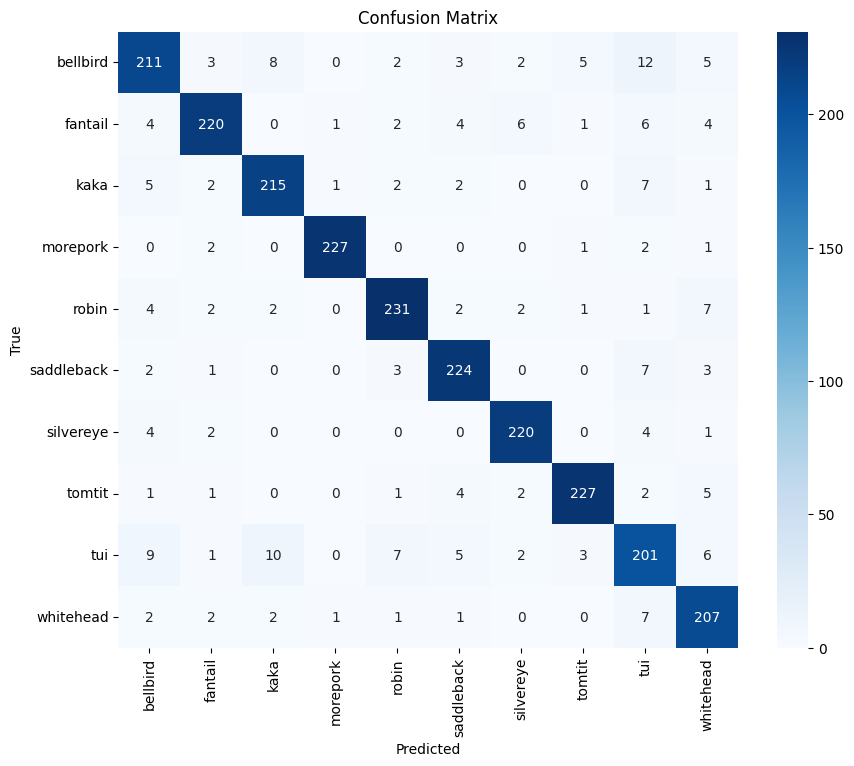

In [10]:
predictions = trainer.predict(dataset_dict['test'])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Accuracy per class
accuracy_per_class = {}
for i, label in enumerate(labels):
    accuracy = np.mean(y_pred[y_true == i] == i)
    accuracy_per_class[label] = accuracy

print("Accuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"{label}: {acc:.2f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# F1 score, precision, recall
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

F1 Score: 0.91
Precision: 0.91
Recall: 0.91


In [ ]:
# import IPython.display as ipd
# misclassified_indices = np.where(y_true != y_pred)[0]
# for idx in misclassified_indices:
#     print(f"Misclassified sample {idx}: true label = {y_true[idx]}, predicted label = {y_pred[idx]}")
#     choice = input("Would you like to listen? (y/n): ")
#     if choice.lower() == "y":
#         sample = dataset_dict['test'][misclassified_indices[0]]
#         ipd.Audio(sample['audio']['path'])

In [12]:
peft_model = trainer.model
merged_model = peft_model.merge_and_unload()
# Ensure label maps and num_labels are embedded in the saved config
merged_model.config.id2label = {str(i): lbl for i, lbl in enumerate(labels)}
merged_model.config.label2id = {lbl: i for i, lbl in enumerate(labels)}
merged_model.config.num_labels = len(labels)

# Save merged model and processor to a clean folder
if os.path.exists(merged_output_dir):
    shutil.rmtree(merged_output_dir)
os.makedirs(merged_output_dir, exist_ok=True)

merged_model.save_pretrained(merged_output_dir)
processor.save_pretrained(merged_output_dir)

print("Merged model and processor saved to", merged_output_dir)
print("Use `from_pretrained` to load the model and processor for inference.")

Merged model and processor saved to ./vit-base-manuai
Use `from_pretrained` to load the model and processor for inference.


In [13]:
!zip -r vit-base-manuai.zip vit-base-manuai
print("Model saved as vit-base-manuai.zip")
print("Training complete. Model and metrics saved.")

  adding: vit-base-manuai/ (stored 0%)
  adding: vit-base-manuai/model.safetensors (deflated 7%)
  adding: vit-base-manuai/config.json (deflated 54%)
  adding: vit-base-manuai/preprocessor_config.json (deflated 47%)
Model saved as vit-base-manuai.zip
Training complete. Model and metrics saved.
